<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/%EB%B0%80%EB%A7%81%ED%97%A4%EB%93%9C_%EB%AA%A8%EB%8B%88%ED%84%B0%EB%A7%81_%EC%8B%A4%EC%8A%B5_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI를 이용한 밀링헤드 모니터링 실습**💡

*   **목적** : 머신비전을 이용하여 밀링헤드의 파손부위를 검출하는 예제

*   **알고리즘** : 객체 검출(Object Detection) 알고리즘 YOLOv5 (출처: https://pytorch.org/hub/ultralytics_yolov5/)

*   **데이터셋** : Edge milling heads Dataset (출처: https://gvis.unileon.es/dataset/edge-milling-heads-dataset-144-images/)

 *해당 데이터셋은 현재 연구목적으로 배포자의 요청 하에만 이용할 수 있으므로 무단 배포 금지*


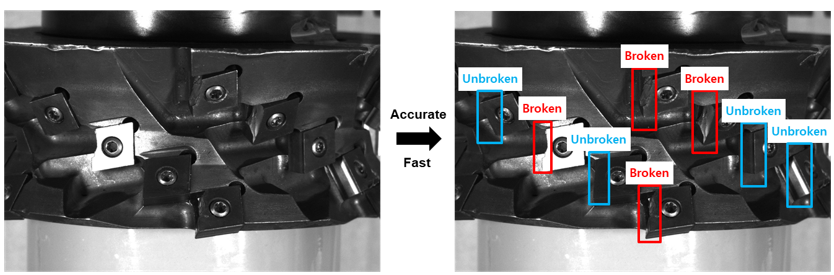



 ## **0. 런타임 유형 변경 (CPU -> GPU)**
 * 딥러닝을 이용한 이미지 학습에는 CPU보다 GPU 연산이 속도가 빠름
 * Colab의 런타임 유형은 CPU가 기본으로 되어있어서 GPU로 변경하는 것이 좋음
 * 메뉴 > 런타임 > 런타임유형변경에서 GPU로 선택을 변경할 수 있음


 ## **1. 데이터 준비**
 ### 1.1. 데이터 소개

* 6개의 밀링헤드에 대하여 각각 24장의 이미지를 촬영하여, 총 120장의 이미지를 저장하고 있음
* 가공 중 밀링헤드의 정지 시점에 약간씩 회전하면서 촬영한 정지영상을 사용하여 파손 여부를 진단함
* 하나의 밀링헤드에는 30개의 insert가 장착되어 있으며, 이 insert 중에서 사용 중에 파손된 insert를 탐지하는 것을 목표로 함
* 정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링


### **1.3. [파일 업로드]**
 * **milling.zip 파일을 Google Drive의 'Colab Notebooks' 폴더에 업로드하시오.**

 * 아래 코드를 실행시켜서 Google Drive에 연결을 승인하시오.

In [ ]:
# 구글 드라이브 연결하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. YOLOv5 코드 불러오기**
* 아래 코드를 실행하여 github에 공개되어 있은 YOLOv5 소스코드들을 Colab으로 불러올 수 있음
* Colab 화면 왼쪽 메뉴의 Colab 저장소에 sample_data 폴더 외에 YOLOv5 폴더가 새롭게 생성되고 그 안에 YOLOv5 소스코드가 저장됨
* zip 파일의 압축을 풀면, Google Drive에서 milling 폴더 하위에 datasets 폴더와 millinghead.yaml(학습설정파일), best_admin.pt(학습모형) 파일을 확인할 수 있습니다.

In [ ]:
# YOLOv5 코드 불러오기
!git clone https://github.com/ultralytics/yolov5

# 관련 라이브러리 설치하기
!pip install ultralytics

# Google Drive의 zip 파일 압축 풀기
%cd '/content/drive/MyDrive/Colab Notebooks/'
!unzip -qq milling.zip

# 설정파일(.yaml)을 yolo5 폴더에 복사하기
%cd '/content/'
!cp '/content/drive/MyDrive/Colab Notebooks/milling/millinghead.yaml' /content/yolov5/data

Cloning into 'yolov5'...
remote: Enumerating objects: 15874, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 15874 (delta 46), reused 45 (delta 15), pack-reused 15769
Receiving objects: 100% (15874/15874), 14.63 MiB | 25.47 MiB/s, done.
Resolving deltas: 100% (10860/10860), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 6.8 MB/s eta 0:00:00
/content/drive/MyDrive/Colab Notebooks
/content


## **3. 데이터 분할 (Training set, Validation set)**

*   총 6개의 밀링헤드에 대하여 총 144장의 이미지 존재 (24장 * 6개 = 144장)

*   1~5번 밀링헤드 이미지 : Training set 및 Validation set으로 사용
*   6번 이미지 : Test set으로 사용

⭐ Training, Validation set 나눌 때, 이미지 내 unbroken insert 개수와 broken insert 개수 비율을 유사하게 나눔 (층화추출)

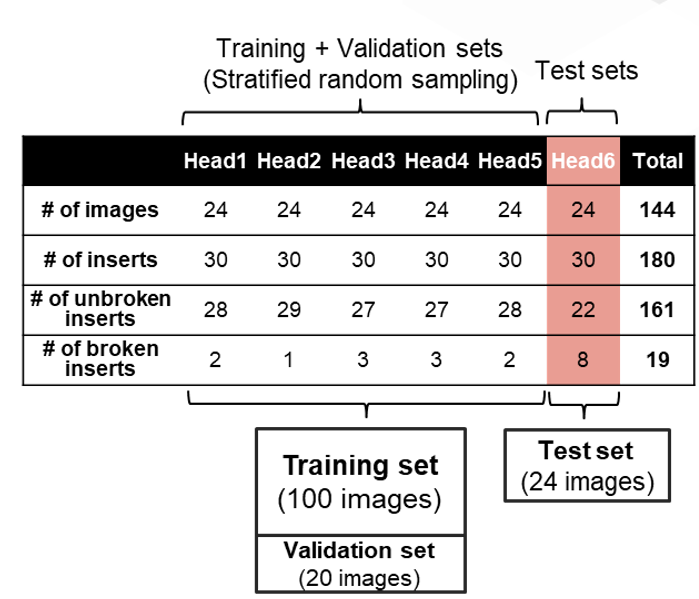

In [ ]:
import numpy as np
import shutil
import os
import datetime

now = datetime.datetime.now()
path = '/content/drive/MyDrive/Colab Notebooks/milling/datasets/'

def load_file(path):
    file_list = os.listdir(path)
    return file_list


# 클래스 개수 추출
def get_class_num(path):
    txt_file_list = load_file(path)
    txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]

    class_array = np.zeros((len(txt_file_list), 3), dtype='int')
    for i, file_name in enumerate(txt_file_list):
        with open(path + '/' + file_name, 'r') as f:
            lines = f.readlines()
            unbroken = 0
            broken = 0
            for line in lines:
                if line[0] == '0':
                    unbroken += 1
                else:
                    broken += 1
        class_array[i] = [int(file_name[-8:-4]), unbroken, broken]
    return class_array


# 비율에 맞게 training vs. validation set 분리
def split_in_strat(class_array):
    unbroken_idx, = np.where(class_array[:, 2] == 0)
    broken_idx, = np.where(class_array[:, 2] != 0)

    unbroken = class_array[unbroken_idx]
    broken = class_array[broken_idx]

    np.random.seed(42)
    np.random.shuffle(unbroken)
    np.random.shuffle(broken)

    print('0 broken distribution')
    print(len(unbroken))

    unique, counts = np.unique(broken[:, 2], return_counts=True)
    di = dict(zip(unique, counts))
    print('broken distribution')
    print(di)

    broken_one_idx, = np.where(broken[:, 2] == 1)
    broken_two_idx, = np.where(broken[:, 2] == 2)
    broken_three_idx, = np.where(broken[:, 2] == 3)
    broken_four_idx, = np.where(broken[:, 2] == 4)

    print('broken_three_idx', len(broken_three_idx))
    print('broken_four_idx', len(broken_four_idx))

    unbroken_img_number_trn = unbroken[:57]
    broken_img_number_trn = np.concatenate((broken[broken_one_idx][:27], broken[broken_two_idx][:14],
                                            broken[broken_three_idx][:2], broken[broken_four_idx][:5]), axis=0)

    unbroken_img_number_val = unbroken[57:]
    broken_img_number_val = np.concatenate((broken[broken_one_idx][27:], broken[broken_two_idx][14:],
                                            broken[broken_three_idx][2:], broken[broken_four_idx][5:]), axis=0)

    trn_img_number = np.sort(np.concatenate((unbroken_img_number_trn[:, 0], broken_img_number_trn[:, 0])))
    val_img_number = np.sort(np.concatenate((unbroken_img_number_val[:, 0], broken_img_number_val[:, 0])))

    print((np.sum(unbroken_img_number_trn[:, 1]) + np.sum(broken_img_number_trn[:, 1])) / np.sum(broken_img_number_trn[:, 2]))
    print((np.sum(unbroken_img_number_val[:, 1]) + np.sum(broken_img_number_val[:, 1])) / np.sum(broken_img_number_val[:, 2]))

    print('trn_img_number', len(trn_img_number))
    print('val_img_number', len(val_img_number))

    return trn_img_number, val_img_number


# Training set 만들기
def make_trn_dataset(img_number):
    trn_txt_file_name = '%s%s%s.%s' % ('./', 'trn', '_filepath', 'txt')
    with open(trn_txt_file_name, 'a') as f: #이미지파일 경로 텍스트 파일 작성
        # 이미지 파일 옮기기
        os.chdir(path + 'images/raw')
        img_file_list = load_file('./')
        img_file_list = [file for file in img_file_list if file.endswith(".bmp")]
        for file_name in img_file_list:
            img_num = int(file_name[8:12])
            if img_num in img_number:
                shutil.copy(file_name, path + 'images/train')
                content = path + 'images/train' + '/' + file_name
                # content_rp = content.replace('\\', '/')
                f.write(content + '\n')

        # bounding box 좌표 텍스트 파일 옮기기
        os.chdir(path + 'labels/raw')
        txt_file_list = load_file('./')
        txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]
        for file_name in txt_file_list:
            txt_num = int(file_name[8:12])
            if txt_num in img_number:
                shutil.copy(file_name, path + 'labels/train')


# Validation set 만들기
def make_val_dataset(img_number):
    os.chdir(path + 'images/raw')
    val_txt_file_name = '%s%s%s.%s' % ('./', 'val', '_filepath', 'txt')
    with open(val_txt_file_name, 'a') as f: #이미지 파일 경로 텍스트 파일 작성
        # 이미지 파일 옮기기
        os.chdir(path + 'images/raw')
        img_file_list = load_file('./')
        img_file_list = [file for file in img_file_list if file.endswith(".bmp")]
        for file_name in img_file_list:
            img_num = int(file_name[8:12])
            if img_num in img_number:
                shutil.copy(file_name, path + 'images/validation')
                content = path + 'images/validation' + '/' + file_name
                # content_rp = content.replace('\\', '/')
                f.write(content + '\n')

        # bounding box 좌표 텍스트 파일 옮기기
        os.chdir(path + 'labels/raw')
        txt_file_list = load_file('./')
        txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]
        for file_name in txt_file_list:
            txt_num = int(file_name[8:12])
            if txt_num in img_number:
                shutil.copy(file_name, path + 'labels/validation')


if __name__ == "__main__":
    class_array = get_class_num(path + 'labels/raw')
    # print(class_array)
    trn_img_number, val_img_number = split_in_strat(class_array)
    print(trn_img_number)
    print(val_img_number)

    make_trn_dataset(trn_img_number)
    make_val_dataset(val_img_number)

0 broken distribution
69
broken distribution
{1: 32, 2: 16, 3: 3}
broken_three_idx 3
broken_four_idx 0
13.262295081967213
13.166666666666666
trn_img_number 100
val_img_number 20
[  1   2   3   4   5   6   7   9  10  11  14  15  16  17  18  19  20  21
  22  23  24  25  29  30  31  32  33  35  36  37  38  39  42  44  45  46
  47  48  50  51  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86
  88  89  90  91  92  93  94  97  98  99 100 101 102 103 105 106 107 108
 109 110 111 113 114 115 117 118 119 120]
[  8  12  13  26  27  28  34  40  41  43  49  52  54  78  87  95  96 104
 112 116]


## **4. 모델 훈련 시켜보기**



In [ ]:
# 훈련이미지 크기:640, 배치 사이즈:16, 에포크 횟수:5, YOLOv5모델:yolov5m

!python /content/yolov5/train.py --data millinghead.yaml --img 640 --batch 16 --epochs 5  --weights yolov5m.pt

requirements: Ultralytics requirement ['gitpython'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 15.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.5s, installed 1 package: ['gitpython']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

train: weights=yolov5m.pt, cfg=, data=millinghead.yaml, hyp=../../../../../../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../../../../../../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dat

### **4.1. 하이퍼파라미터 튜닝**

*   모델 훈련에 사용되는 학습률, IoU 임계값 등을 설정함
*   yolov5-master/data/hyps 경로에 파라미터 설정 파일 존재
*   데이터 augmentation
  - translate (이미지 이동)
  - shear (기울임)
  - rotation (회전)
  - fliplr (좌우반전): 0.5 -> 0.0 (probability)
  - flipup (상하반전): 0.0 -> 0.5 (probability)














### **4.2. 모델 훈련 실행**

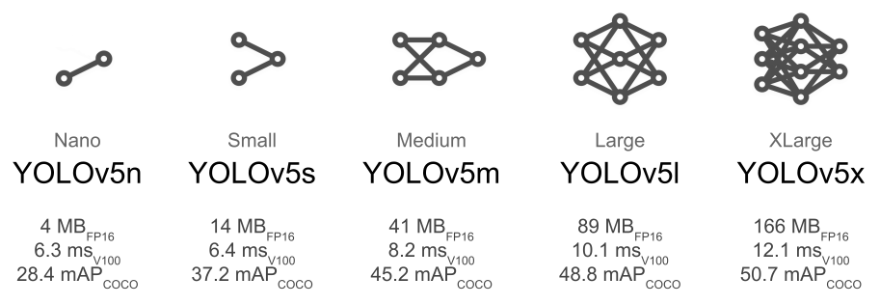
*   **--img** : 훈련 이미지 크기
*   **--batch** : 배치사이즈 크기
*   **--epochs** : 훈련 에포크 횟수
*   **--patience** : 훈련 조기종료 임계값
*   **--data** : .yaml 파일 경로
*   **--weights** : pretrained 모델 가중치



> 파라미터 관련 참고: https://github.com/ultralytics/yolov5/blob/master/train.py (474~517 lines)



## **5. 모델 테스트하기**




### **5.1 우수 모델로 테스트 해보기**

**사전에 학습된 모형(best_admin.pt)으로 진단해보기**
*   zip 파일 내에는 밀링헤드 모니터링에 대하여 이미 학습되어 있는 best_admin.pt 파일이 있습니다.
*   아래 코드를 실행하여, best_admin.pt 파일을 Colab의 아래 경로(/yolov5/runs/train/exp/weights/)에 복사한 후, 테스트해보시오.

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/milling/best_admin.pt' /content//yolov5/runs/train/exp/weights

!python /content/yolov5/val.py --weights '/content/yolov5/runs/train/exp/weights/best_admin.pt' --data millinghead.yaml --img 640 --conf-thres 0.5 --batch-size 1 --task 'test'

val: data=/content/yolov5/data/millinghead.yaml, weights=['/content/yolov5/runs/train/exp/weights/best_admin.pt'], batch_size=1, imgsz=640, conf_thres=0.5, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../../../../../../../yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-203-g0897415 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 290 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning /content/drive/MyDrive/Colab Notebooks/milling/datasets/labels/test... 24 images, 0 backgrounds, 0 corrupt: 100% 24/24 [00:00<00:00, 148.22it/s]
test: New cache created: /content/drive/MyDrive/Colab Notebooks/milling/datasets/labels/test.cache
                 Class     Images  Instances          P          R

### **5.2 객체 검출 결과 저장하기**

**test 이미지에서 객체 검출한 후, 아래 경로에 저장합니다.**

In [ ]:
import os
import torch

# 훈련된 모델 가중치 저장 경로
model_path = '/content/yolov5/runs/train/exp/weights/best_admin.pt'

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', model_path)

# 테스트 이미지 목록 불러오기
os.chdir(path + 'images/test')
test_img_file_list = os.listdir(path + 'images/test')
test_img_file_list = [file for file in test_img_file_list if file.endswith(".bmp")]
print(test_img_file_list)

# Inference
model.conf = 0.3
model.iou = 0.5
results = model(test_img_file_list)

# Results
results.save() # or .print(), .show(), .save(), .crop(), .pandas(), etc.

# 아래 경로에 저장됨: /content/drive/MyDrive/Colab Notebooks/milling/datasets/images/test/runs/detect/exp

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 290 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


['HeadTool0124.bmp', 'HeadTool0123.bmp', 'HeadTool0121.bmp', 'HeadTool0127.bmp', 'HeadTool0122.bmp', 'HeadTool0126.bmp', 'HeadTool0130.bmp', 'HeadTool0125.bmp', 'HeadTool0134.bmp', 'HeadTool0129.bmp', 'HeadTool0131.bmp', 'HeadTool0133.bmp', 'HeadTool0128.bmp', 'HeadTool0132.bmp', 'HeadTool0137.bmp', 'HeadTool0139.bmp', 'HeadTool0140.bmp', 'HeadTool0136.bmp', 'HeadTool0135.bmp', 'HeadTool0144.bmp', 'HeadTool0143.bmp', 'HeadTool0142.bmp', 'HeadTool0141.bmp', 'HeadTool0138.bmp']


Saved 24 images to runs/detect/exp
